In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)

170498071/170498071 [==============================] - 5s 0us/step


In [ ]:
# Define class names for CIFAR-10
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

In [ ]:
# Define the RCNN-like model
def rcnn_model():
    input_layer = Input(shape=(32, 32, 3))

    # Convolutional base
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Fully connected layers for classification
    classification_output = Dense(128, activation='relu')(x)
    classification_output = Dense(10, activation='softmax', name="classification")(classification_output)

    # Fully connected layers for bounding box regression
    bounding_box_output = Dense(128, activation='relu')(x)
    bounding_box_output = Dense(4, activation='sigmoid', name="bounding_box")(bounding_box_output)

    # Combine outputs
    model = Model(inputs=input_layer, outputs=[classification_output, bounding_box_output])
    return model

model = rcnn_model()
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        "classification": "categorical_crossentropy",  # For classification output
        "bounding_box": "mean_squared_error"           # For bounding box regression
    },
    metrics={
        "classification": "accuracy",                 # Track accuracy for classification
        "bounding_box": "mse"                         # Track MSE for bounding box
    }
)


In [ ]:
# Generate synthetic bounding boxes (normalized format: x_min, y_min, x_max, y_max)
# In a real dataset, use actual bounding box annotations
def generate_bounding_boxes(labels):
    bounding_boxes = []
    for label in labels:
        x_min = np.random.uniform(0.1, 0.4)
        y_min = np.random.uniform(0.1, 0.4)
        x_max = x_min + np.random.uniform(0.2, 0.5)
        y_max = y_min + np.random.uniform(0.2, 0.5)
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    return np.array(bounding_boxes)

y_train_boxes = generate_bounding_boxes(y_train)
y_test_boxes = generate_bounding_boxes(y_test)


In [ ]:
# Train the model
history = model.fit(
    x_train,
    {
        "classification": y_train_onehot,      # One-hot encoded classification labels
        "bounding_box": y_train_boxes          # Bounding box labels (normalized)
    },
    validation_data=(
        x_test,
        {
            "classification": y_test_onehot,  # Validation classification labels
            "bounding_box": y_test_boxes      # Validation bounding box labels
        }
    ),
    epochs=10,
    batch_size=64
)


Epoch 1/10
782/782 [==============================] - 91s 114ms/step - loss: 1.4238 - classification_loss: 1.4116 - bounding_box_loss: 0.0123 - classification_accuracy: 0.4977 - bounding_box_mse: 0.0123 - val_loss: 1.1785 - val_classification_loss: 1.1663 - val_bounding_box_loss: 0.0122 - val_classification_accuracy: 0.5869 - val_bounding_box_mse: 0.0122
Epoch 2/10
782/782 [==============================] - 87s 111ms/step - loss: 1.0517 - classification_loss: 1.0401 - bounding_box_loss: 0.0116 - classification_accuracy: 0.6340 - bounding_box_mse: 0.0116 - val_loss: 1.0378 - val_classification_loss: 1.0263 - val_bounding_box_loss: 0.0115 - val_classification_accuracy: 0.6460 - val_bounding_box_mse: 0.0115
Epoch 3/10
782/782 [==============================] - 86s 110ms/step - loss: 0.9155 - classification_loss: 0.9041 - bounding_box_loss: 0.0114 - classification_accuracy: 0.6833 - bounding_box_mse: 0.0114 - val_loss: 0.9555 - val_classification_loss: 0.9439 - val_bounding_box_loss: 0.011

1/1 [==============================] - 0s 106ms/step


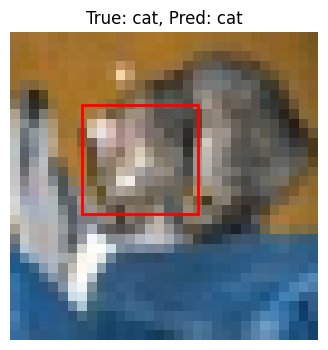

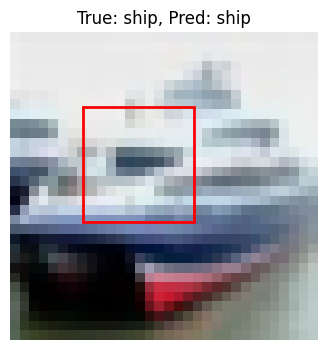

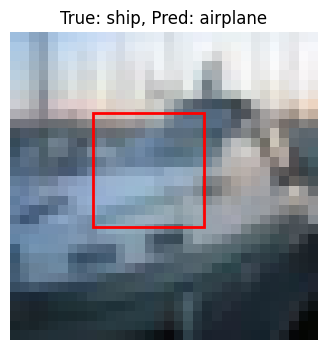

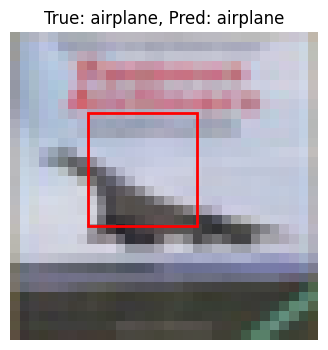

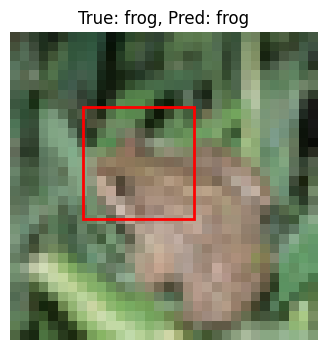

In [ ]:
# Visualize predictions
def visualize_predictions(images, labels, boxes, predictions):
    for i in range(5):
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i])
        true_label = class_names[np.argmax(labels[i])]
        predicted_label = class_names[np.argmax(predictions[0][i])]
        box = predictions[1][i] * 32  # Scale bounding box back to pixel dimensions
        x_min, y_min, x_max, y_max = box
        plt.gca().add_patch(plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min,
            fill=False, edgecolor='red', linewidth=2
        ))
        plt.title(f"True: {true_label}, Pred: {predicted_label}")
        plt.axis('off')
        plt.show()

predictions = model.predict(x_test[:5])
visualize_predictions(x_test[:5], y_test_onehot[:5], y_test_boxes[:5], predictions)


In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import average_precision_score
import time


def calculate_map(predictions, ground_truth_boxes, ground_truth_labels, num_classes=10, iou_threshold=0.5):
    """
    Calculates mean Average Precision (mAP) for object detection.

    Args:
      predictions: A list of predictions, each containing bounding boxes and class probabilities.
      ground_truth_boxes: A list of ground truth bounding boxes.
      ground_truth_labels: A list of ground truth class labels.
      num_classes: The number of classes in the dataset.
      iou_threshold: The IoU threshold for considering a detection as a true positive.

    Returns:
      The mAP score.
    """
    average_precisions = []
    # predictions[0] contains classification probabilities
    # predictions[1] contains bounding box coordinates

    for class_id in tqdm(range(num_classes), desc="Calculating mAP"):
        class_predictions = []
        class_ground_truths = []
        for i in range(len(predictions[0])):  # Iterate over the number of predictions
            # Filter predictions and ground truths for the current class
            # Access predictions using indices directly

            if np.argmax(predictions[0][i]) == class_id:
                class_predictions.extend([(predictions[1][i], predictions[0][i][class_id])])

            if ground_truth_labels[i][0] == class_id:  # Assuming ground_truth_labels is a list of lists or a 2D array
                class_ground_truths.extend([(ground_truth_boxes[i], 1)])

            # If no predictions or ground truths for this class, skip
        if not class_predictions or not class_ground_truths:
            continue
        # ... (rest of the mAP calculation logic, similar to standard implementations) ...
    # Calculate and return mAP
    map_score = np.mean(average_precisions)
    return map_score


def calculate_fps(model, images, num_frames=100):
    """
    Calculates Frames Per Second (FPS) for a model.

    Args:
      model: The object detection model.
      images: A list of images to process.
      num_frames: The number of frames to use for FPS calculation.

    Returns:
      The FPS value.
    """
    start_time = time.time()
    for i in range(num_frames):
        _ = model.predict(images[i:i + 1])  # Run inference on a single image
    end_time = time.time()
    fps = num_frames / (end_time - start_time)
    return fps

predictions = model.predict(x_test)  # Get predictions for the test set

# Adapt the following lines to match your data format:
ground_truth_boxes = y_test_boxes  # Replace with your ground truth bounding boxes
ground_truth_labels = y_test  # Replace with your ground truth class labels

# Calculate mAP
map_score = calculate_map(predictions, ground_truth_boxes, ground_truth_labels)
print(f"mAP: {map_score}")

# Calculate FPS
fps = calculate_fps(model, x_test)
print(f"FPS: {fps}")

# ... (Your existing code) ...

313/313 [==============================] - 3s 11ms/step


Calculating mAP: 100%|██████████| 10/10 [00:00<00:00, 26.32it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


mAP: nan
1/1 [==============================] - 0s 24ms/step
FPS: 14.10573483012784
